<a href="https://colab.research.google.com/github/DanielRasho/Paralela-proj3/blob/main/testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tests

In [2]:
%%bash
set -euo pipefail

cd Paralela-proj3-main/src

# Detectar modelo y elegir compute capability (CC)
GPU_NAME="$(nvidia-smi --query-gpu=name --format=csv,noheader 2>/dev/null | head -n1 || echo "unknown")"
echo "GPU detectada: ${GPU_NAME}"

CC=""
case "${GPU_NAME}" in
  *"T4"*)         CC="75" ;;   # Tesla T4 (Turing)
  *"V100"*)       CC="70" ;;   # Tesla V100 (Volta)
  *"P100"*)       CC="60" ;;   # Tesla P100 (Pascal)
  *"A100"*)       CC="80" ;;   # A100 (Ampere)
  *"L4"*)         CC="89" ;;   # L4 (Ada Lovelace)
  *"A10"*)        CC="86" ;;   # A10 (Ampere)
  *"A40"*)        CC="86" ;;   # A40 (Ampere)
  *"RTX 30"*"90"*) CC="86" ;;   # 3090 etc.
  *"RTX 40"*"90"*) CC="89" ;;   # 4090 etc.
  *)              CC="75" ;;   # fallback razonable
esac
echo "Usando compute capability sm_${CC}"

# Recompilar SOLO GPU sin dejar PTX (solo SASS para evitar JIT del driver)
rm -f gpu_exec
nvcc -O2 globa.cu -o gpu_exec -lpng \
  -gencode arch=compute_${CC},code=sm_${CC}

echo "Lanzando GPU..."
./gpu_exec ../media/runway.pgm ../media/gpu_out.png || {
  echo "⚠️  Falló la ejecución GPU. Revisa que el runtime tenga GPU habilitada y vuelve a correr."
  exit 1
}

echo "Listando salidas:"
ls -lh ../media | sed -n '1,200p'
echo "OK"


GPU detectada: Tesla T4
Usando compute capability sm_75
Lanzando GPU...
==== CUDA Hough Transform (Global Memory) ====
Input image: ../media/runway.pgm
Output image: ../media/gpu_out.png
Threshold: 2100 votes

Image dimensions: 800 x 600
Edge pixels detected: 138406 (28.83%)

Hough Transform Parameters:
  rMax = 500.00
  rScale = 5.00
  degreeBins = 90
  rBins = 200
  Accumulator size = 18000 bins

CUDA Kernel Configuration:
  Block size: 256 threads
  Grid size: 1875 blocks
  Total threads: 480000

Launching kernel...
Kernel completed!

==== Detected Lines (threshold = 2100 votes) ====
Line 0: theta=110.00 deg (1.9199 rad), r=-155.00, votes=2151
Line 1: theta=106.00 deg (1.8500 rad), r=-150.00, votes=2123
Line 2: theta=108.00 deg (1.8850 rad), r=-150.00, votes=2107
Line 3: theta=110.00 deg (1.9199 rad), r=-150.00, votes=2157
Line 4: theta=112.00 deg (1.9548 rad), r=-150.00, votes=2114
Line 5: theta=70.00 deg (1.2217 rad), r=-145.00, votes=2189
Line 6: theta=72.00 deg (1.2566 rad), r=-

globa.cu(31): warning #1650-D: result of call is not used
      fscanf(file, "%2s", magic);
      ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

globa.cu(48): warning #1650-D: result of call is not used
      fscanf(file, "%d %d", &img->x_dim, &img->y_dim);
      ^

globa.cu(49): warning #1650-D: result of call is not used
      fscanf(file, "%d", &img->max_gray);
      ^

globa.cu(60): warning #1650-D: result of call is not used
      fread(img->pixels, 1, img->x_dim * img->y_dim, file);
      ^

globa.cu(31): warning #1650-D: result of call is not used
      fscanf(file, "%2s", magic);
      ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

globa.cu(48): warning #1650-D: result of call is not used
      fscanf(file, "%d %d", &img->x_dim, &img->y_dim);
      ^

globa.cu(49): warning #1650-D: result of call is not used
      fscanf(file, "%d", &img->max_gray);
      ^

globa.cu(60): warning #1650-D: result of call is no

#  Validación funcional CPU vs GPU (Global Memory)

Comparamos las salidas gráficas de ambas implementaciones (`cpu_out.png` vs `gpu_out.png`) y cuantificamos la diferencia con **MSE**.  
Esperado: MSE ≈ 0 y diferencias visuales mínimas.


MSE CPU vs GPU: 0.000000


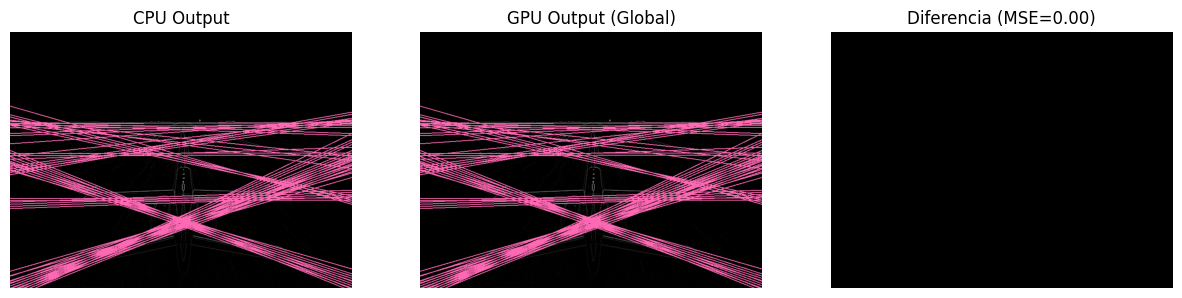

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

cpu_path = Path("Paralela-proj3-main/media/cpu_out.png")
gpu_path = Path("Paralela-proj3-main/media/gpu_out.png")

imgs, titles = [], []
cpu_img = gpu_img = None

if cpu_path.exists():
    cpu_img = np.array(Image.open(cpu_path)); imgs.append(cpu_img); titles.append("CPU Output")
if gpu_path.exists():
    gpu_img = np.array(Image.open(gpu_path)); imgs.append(gpu_img); titles.append("GPU Output (Global)")

if imgs:
    cols = len(imgs) + (1 if (cpu_img is not None and gpu_img is not None) else 0)
    plt.figure(figsize=(5*cols, 4))
    for i,(im,tt) in enumerate(zip(imgs, titles), start=1):
        plt.subplot(1, cols, i); plt.imshow(im); plt.axis('off'); plt.title(tt)
    if cpu_img is not None and gpu_img is not None:
        diff = np.abs(cpu_img.astype(int) - gpu_img.astype(int))
        mse = np.mean(diff**2)
        plt.subplot(1, cols, cols); plt.imshow(diff); plt.axis('off'); plt.title(f"Diferencia (MSE={mse:.2f})")
        print(f"MSE CPU vs GPU: {mse:.6f}")
    plt.show()
else:
    print("No hay imágenes para mostrar.")


# Métricas de rendimiento: CPU vs GPU (Global Memory)

Objetivo: medir rendimiento **end-to-end** (lectura → Hough → escritura PNG) en **CPU** y **GPU (memoria global)**.
Metodología:
- Recompilar binarios (GPU con `sm_75` para Tesla T4).
- 1 corrida de *warm-up* por backend (inicializa contexto/IO).
- N repeticiones (p.ej. N=10) y cálculo de: media, desv. estándar, p50, p95.
- **Speedup = mean(CPU) / mean(GPU)**.

Nota: estas métricas incluyen E/S de disco y escritura PNG. Más adelante podemos aislar solo el cómputo si el proyecto lo requiere.


In [4]:
%%bash
set -euo pipefail
cd Paralela-proj3-main/src

# limpiar binarios previos
rm -f cpu_exec gpu_exec

# CPU (g++)
g++ -x c++ -std=gnu++17 -O2 cpu.cu -o cpu_exec -lm -lpng

# Detectar GPU y fijar sm_75 (T4). Si se quisiera generalizar, se puede detectar dinámicamente.
nvcc -O2 globa.cu -o gpu_exec -lpng -gencode arch=compute_75,code=sm_75

echo "Binarios listos:"
ls -l cpu_exec gpu_exec


Binarios listos:
-rwxr-xr-x 1 root root   21560 Nov  3 22:31 cpu_exec
-rwxr-xr-x 1 root root 1011576 Nov  3 22:31 gpu_exec


cpu.cu: In function ‘int readPGM(const char*, PGMImage*)’:
cpu.cu:30:11: warning: ignoring return value of ‘int fscanf(FILE*, const char*, ...)’ declared with attribute ‘warn_unused_result’ [-Wunused-result]
   30 |     fscanf(file, "%2s", magic);
      |     ~~~~~~^~~~~~~~~~~~~~~~~~~~
cpu.cu:47:11: warning: ignoring return value of ‘int fscanf(FILE*, const char*, ...)’ declared with attribute ‘warn_unused_result’ [-Wunused-result]
   47 |     fscanf(file, "%d %d", &img->x_dim, &img->y_dim);
      |     ~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cpu.cu:48:11: warning: ignoring return value of ‘int fscanf(FILE*, const char*, ...)’ declared with attribute ‘warn_unused_result’ [-Wunused-result]
   48 |     fscanf(file, "%d", &img->max_gray);
      |     ~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~
cpu.cu:59:10: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’ declared with attribute ‘warn_unused_result’ [-Wunused-result]
   59 |     fread(img->pixels, 1, img->x_di

## Parámetros de la batería y *warm-up*

- Imagen: `media/runway.pgm`
- Salidas: `media/cpu_bench.png` y `media/gpu_bench.png`
- Repeticiones: `N=10` (modificable)
- Se ejecuta 1 *warm-up* previo para amortiguar costos de primera llamada (especialmente en GPU).


In [5]:
import time, subprocess, statistics
from pathlib import Path
import pandas as pd
from math import isnan

ROOT = Path("Paralela-proj3-main")
SRC  = ROOT / "src"
IMG  = ROOT / "media" / "runway.pgm"
OUTC = ROOT / "media" / "cpu_bench.png"
OUTG = ROOT / "media" / "gpu_bench.png"

CPU_BIN = SRC / "cpu_exec"
GPU_BIN = SRC / "gpu_exec"

def run_timed(cmd):
    """Ejecuta un comando y devuelve el tiempo (segundos, float). Lanza excepción si falla."""
    t0 = time.perf_counter()
    subprocess.run(cmd, check=True)
    t1 = time.perf_counter()
    return t1 - t0

# Warm-up (no medimos, solo para inicializar)
print("Warm-up CPU...")
subprocess.run([str(CPU_BIN), str(IMG), str(OUTC)], check=True)

print("Warm-up GPU...")
try:
    subprocess.run([str(GPU_BIN), str(IMG), str(OUTG)], check=True)
except Exception as e:
    print("Warm-up GPU falló. ¿GPU activa? Detalle:", e)


Warm-up CPU...
Warm-up GPU...


## Ejecución de N repeticiones y captura de tiempos

Se registran tiempos totales por repetición para CPU y GPU.  
Luego se calcula: **media, desviación estándar, p50 y p95**, y el **speedup**.


In [6]:
N = 10  # ajustable

cpu_times, gpu_times = [], []

print(f"Corriendo {N} repeticiones en CPU...")
for i in range(N):
    dt = run_timed([str(CPU_BIN), str(IMG), str(OUTC)])
    cpu_times.append(dt)

print(f"Corriendo {N} repeticiones en GPU...")
for i in range(N):
    try:
        dt = run_timed([str(GPU_BIN), str(IMG), str(OUTG)])
        gpu_times.append(dt)
    except Exception as e:
        print(f"Repetición GPU {i} falló:", e)
        gpu_times.append(float("nan"))

def stats(xs):
    xs_ok = [x for x in xs if not isnan(x)]
    if not xs_ok:
        return dict(mean=float("nan"), std=float("nan"), p50=float("nan"), p95=float("nan"), min=float("nan"), max=float("nan"))
    xs_sorted = sorted(xs_ok)
    p50 = xs_sorted[len(xs_sorted)//2]
    p95 = xs_sorted[max(0, int(round(0.95*(len(xs_sorted)-1))))]
    return dict(
        mean = statistics.mean(xs_ok),
        std  = statistics.pstdev(xs_ok),
        p50  = p50,
        p95  = p95,
        min  = min(xs_ok),
        max  = max(xs_ok),
    )

cpu_s = stats(cpu_times)
gpu_s = stats(gpu_times)

df = pd.DataFrame([
    {"Backend": "CPU (end-to-end)", **cpu_s},
    {"Backend": "GPU Global (end-to-end)", **gpu_s},
])

# Speedup
speedup = float("nan")
if not isnan(cpu_s["mean"]) and not isnan(gpu_s["mean"]) and gpu_s["mean"] > 0:
    speedup = cpu_s["mean"] / gpu_s["mean"]

print("\nResultados por backend (segundos):")
display(df)
print(f"\nSpeedup ≈ CPU_mean / GPU_mean = {speedup:.2f}x")


Corriendo 10 repeticiones en CPU...
Corriendo 10 repeticiones en GPU...

Resultados por backend (segundos):


,Backend,mean,std,p50,p95,min,max
0,CPU (end-to-end),0.277272,0.129296,0.231527,0.664297,0.226002,0.664297
1,GPU Global (end-to-end),0.320034,0.038201,0.313392,0.369958,0.276906,0.369958



Speedup ≈ CPU_mean / GPU_mean = 0.87x


## Gráfica de comparación (promedios)

Se grafica el **promedio** de tiempo por backend como barras.  
La desviación estándar puede agregarse como texto o en una tabla aparte (arriba).


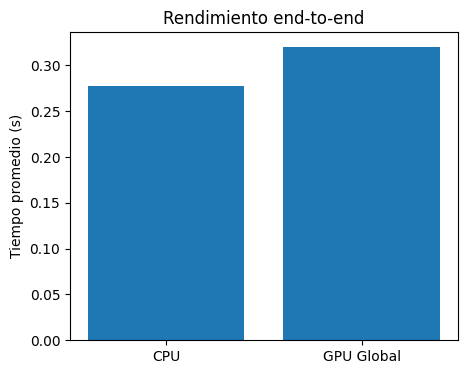

In [7]:
import matplotlib.pyplot as plt

labels = ["CPU", "GPU Global"]
means  = [df.loc[df["Backend"]=="CPU (end-to-end)", "mean"].values[0],
          df.loc[df["Backend"]=="GPU Global (end-to-end)", "mean"].values[0]]

plt.figure(figsize=(5,4))
plt.bar(labels, means)
plt.ylabel("Tiempo promedio (s)")
plt.title("Rendimiento end-to-end")
plt.show()
